In [12]:
#abc

In [13]:
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
import urllib.request
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time 

In [14]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

In [15]:
model = hub.load(module_handle)

In [16]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7FED18BB51C0>}))

In [17]:
detector = model.signatures['default']

In [18]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.imshow(image)

In [19]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

    with urllib.request.urlopen(url) as url_response:
        image_data = url_response.read()
    
    # opens the image
    pil_image = Image.open(BytesIO(image_data))
    
    # resizes the image. will crop if aspect ratio is different.
    pil_image.thumbnail((new_width, new_height), Image.ANTIALIAS)
    
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
    pil_image.save(temp_file.name, format="JPEG", quality=90)
    
    if display:
        display_image(pil_image)
        
    print(f"Image downloaded to {temp_file.name}.")
    return temp_file.name

Image downloaded to /tmp/tmpkx48sey9.jpg.


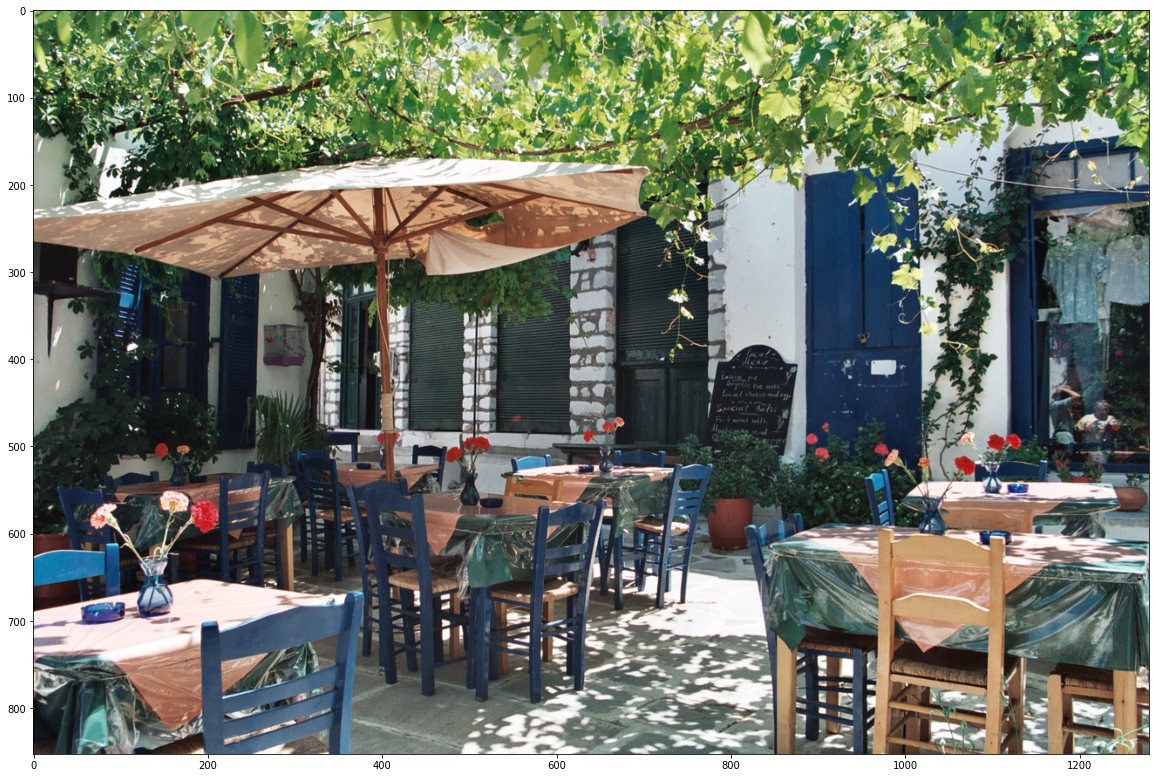

In [20]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [21]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [22]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
 
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

In [23]:
def load_img(path):

    # read the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


def run_detector(detector, path):
    
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    # display the image
    display_image(image_with_boxes)

Found 100 objects.
Inference time:  9.115196943283081


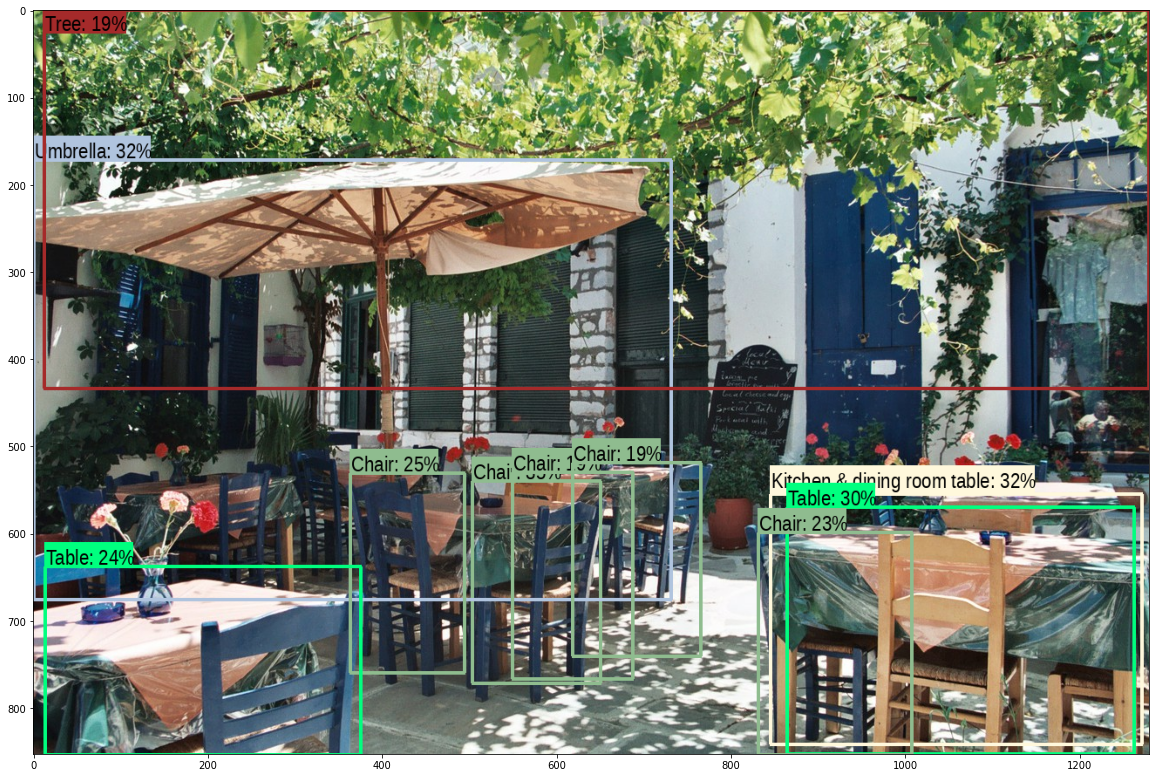

In [24]:
run_detector(detector, downloaded_image_path)

In [25]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmp7h_g7i06.jpg.
Found 100 objects.
Inference time:  0.22108721733093262
Inference time: 0.524944543838501


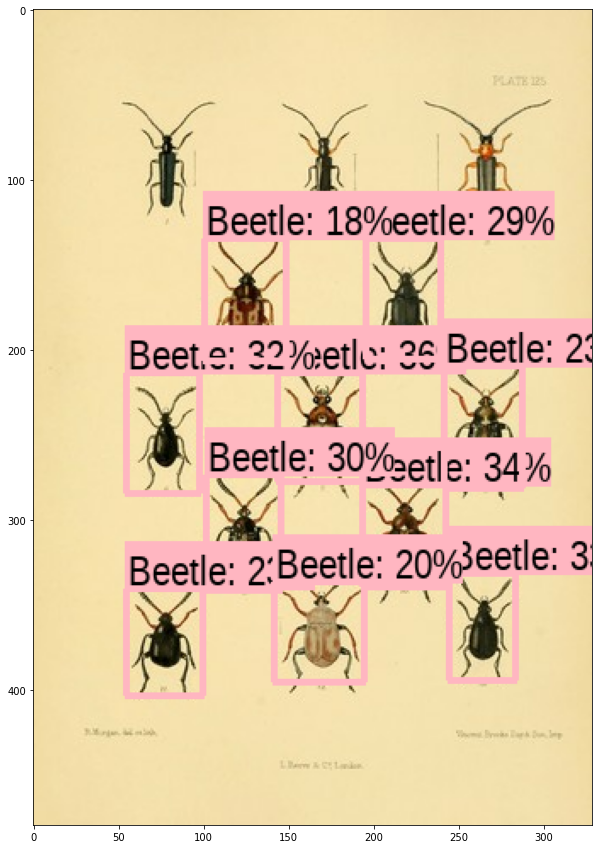

In [26]:
detect_img(image_urls[0])

Image downloaded to /tmp/tmp03rnlwyr.jpg.
Found 100 objects.
Inference time:  0.21309709548950195
Inference time: 0.45352721214294434


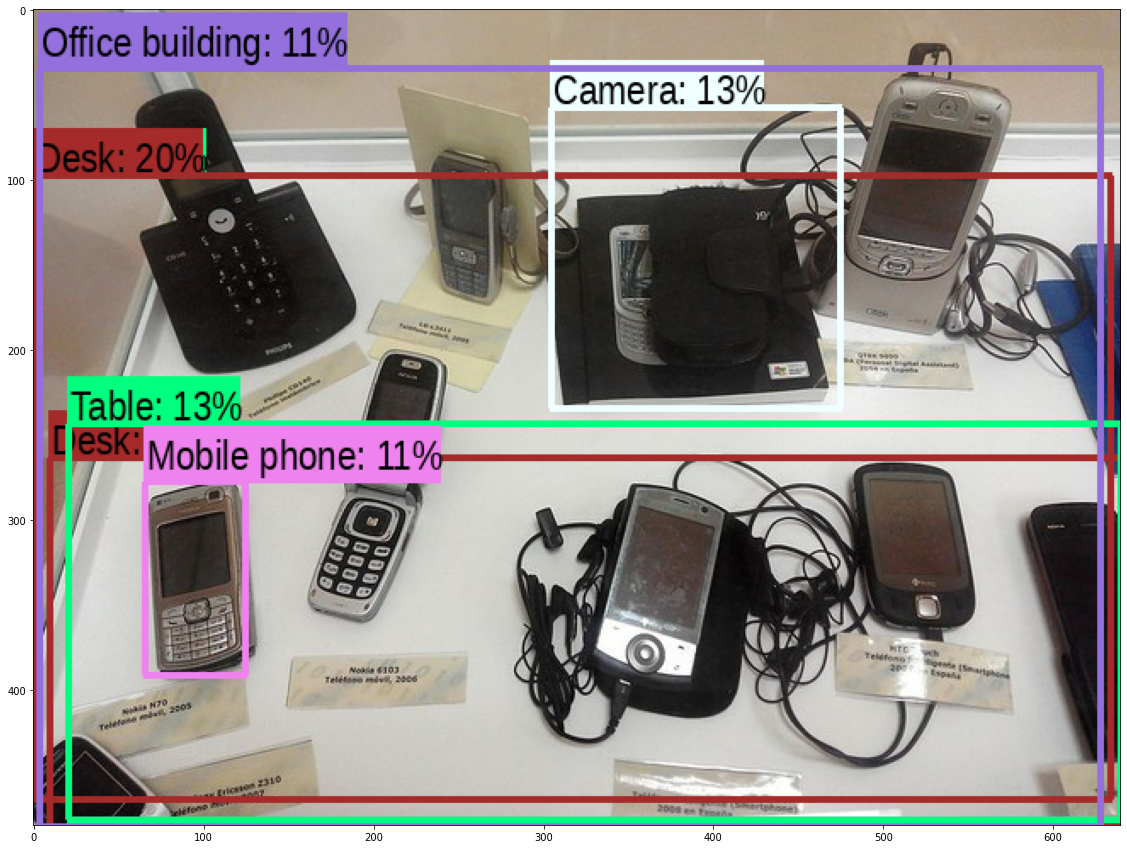

In [27]:
detect_img(image_urls[1])

Image downloaded to /tmp/tmp0uwe82gj.jpg.
Found 100 objects.
Inference time:  0.21390056610107422
Inference time: 0.6846668720245361


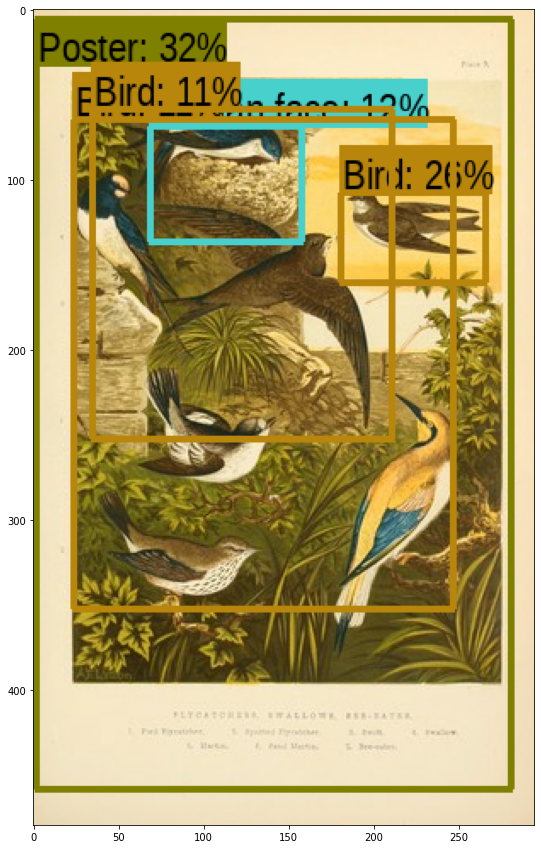

In [28]:
detect_img(image_urls[2])